In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
ScopusAIphys = pd.read_csv('./../Data/Curated_Dataset/Raw_AI_Join_on_Query_Terms_Technical_Physical_Science_1997_2018_20191104.csv')
ScopusAIsoc = pd.read_csv('./../Data/Curated_Dataset/Raw_AI_Join_on_Query_Terms_Social_Science_1997_2018_20191104.csv')

In [3]:
UniquePhys = pd.unique(ScopusAIphys['EID'])
AllPhys = ScopusAIphys
UniqueSoc = pd.unique(ScopusAIsoc['EID'])
AllSoc = ScopusAIsoc
ScopusAI = pd.concat([ScopusAIphys, ScopusAIsoc])
AllKeys = ScopusAI['Keyword'].unique()
UniqueAll = pd.unique(ScopusAI['EID'])
Intersection = set(ScopusAIphys['EID']).intersection( set(ScopusAIsoc['EID'] ) )

In [4]:
#### Gathering all the keyword publication counts per year from the Scopus curated 
#### AI dataset
begin = time.time()
CombYears = []

years = []
for k in AllKeys:
    year = []
#     year.append(k)
    for i in range(1997,2019):
        buf = ScopusAI['EID'][(ScopusAI['Keyword'] == k) & (ScopusAI['sort_year']  == i)].count() 
        year.append(buf)
    years.append(year)
years = np.array(years)
end = time.time()
print(end-begin)

51.27371907234192


In [5]:
# convert_dict = {'Query' : str, }
convert_dict = {}


for i in range(1997,2019):
    convert_dict.update({i : float})
# names = list( ['Query'] + list( range(1997,2019) ) )
names = list( range(1997,2019) )
Data = pd.DataFrame(years, columns=names, index=AllKeys)
Data = Data.astype(convert_dict)
# Data = Data.T
# Data_phys = Data.iloc[:29]
# Data_soc = Data.iloc[29:]

#### Clustering the keywords

In [6]:
SL = Data.iloc[[1,3,4,6,7,12,19,20,27]].sum()
UL = Data.iloc[[2,13]].sum()
RL = Data.iloc[[8,16]].sum()

ELSI = Data.iloc[[31,32,39,40,41,42,46,47,49,50,52,57]].sum()
FE = Data.iloc[[30,36,51,61]].sum()
RG = Data.iloc[[37,44,45,48,53,54,55,58,60]].sum()
RD = Data.iloc[[34,38,43,56,59]].sum()

In [7]:
ClustData = pd.DataFrame([SL,UL,RL,ELSI,FE,RG,RD], index=['SL','UL','RL','ELSI','FE','RG','RD']).T

In [8]:
stat,p = stats.normaltest(ClustData.ELSI)
print('Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('Pubs for ELSI look Gaussian (failed to reject H0)')
else:
    print('Pubs for ELSI do not look Gaussian (rejected H0)')

Statistics=8.920, p=0.012
Pubs for ELSI do not look Gaussian (rejected H0)


In [9]:
print('Kurtosis of normal distribution: {}'. format(stats.kurtosis(ClustData.ELSI) ) )
print('Skewness of normal distribution: {}'. format(stats.skew(ClustData.ELSI) ) )

Kurtosis of normal distribution: 0.9510238968906233
Skewness of normal distribution: 1.2617974635795801


count      22.000000
mean     1915.181818
std      1719.339343
min       234.000000
25%       535.750000
50%      1624.000000
75%      2748.000000
max      6182.000000
Name: ELSI, dtype: float64

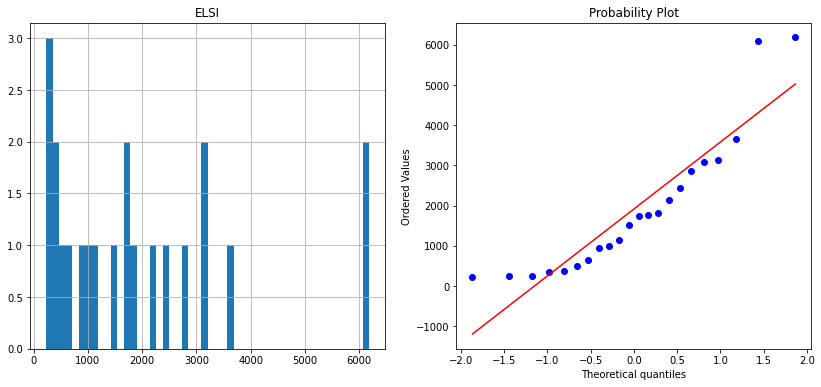

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ClustData.ELSI.hist(bins=50)
plt.title('ELSI')
plt.subplot(1,2,2)
stats.probplot(ClustData.ELSI, plot=plt);
ClustData.ELSI.describe().T

In [11]:
stat,p = stats.normaltest(ClustData.SL)
print('Statistics=%.3f, p=%.3f' % (stat,p))
alpha = 0.05
if p > alpha:
    print('Pubs for SL look Gaussian (failed to reject H0)')
else:
    print('Pubs for SL do not look Gaussian (rejected H0)')

Statistics=24.835, p=0.000
Pubs for SL do not look Gaussian (rejected H0)


In [12]:
print('Kurtosis of normal distribution: {}'. format(stats.kurtosis(ClustData.SL) ) )
print('Skewness of normal distribution: {}'. format(stats.skew(ClustData.SL) ) )

Kurtosis of normal distribution: 4.806234551265816
Skewness of normal distribution: 2.147236293474901


count       22.000000
mean     18364.954545
std      13701.544204
min       6445.000000
25%       8679.250000
50%      17100.000000
75%      19224.500000
max      65746.000000
Name: SL, dtype: float64

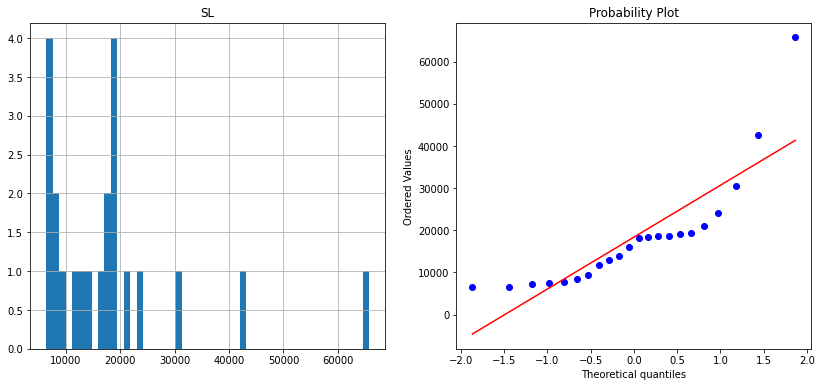

In [13]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ClustData.SL.hist(bins=50)
plt.title('SL')
plt.subplot(1,2,2)
stats.probplot(ClustData.SL, plot=plt);
ClustData.SL.describe().T

### Correlation matrix for the clusters (Pearson and symmetric due to multiplicative commutativity)

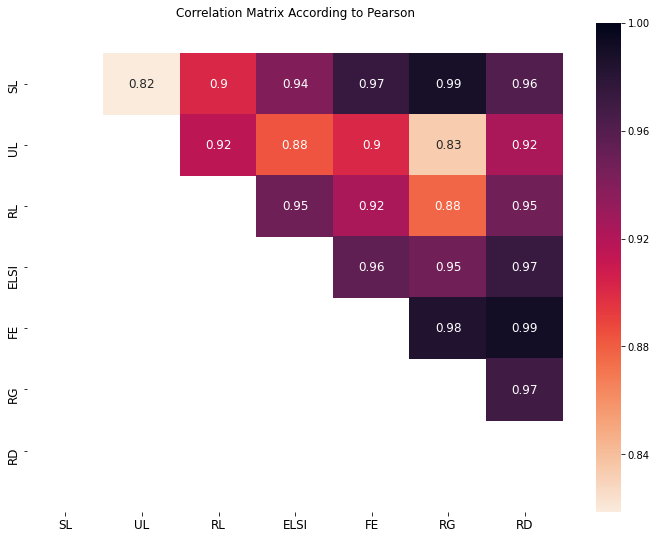

In [67]:
plt.figure(figsize=(12,9))
corr = ClustData.corr()
mask = np.tril(np.ones_like(corr, dtype=np.bool))
cmap = sns.cm.rocket_r
ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns.values, cmap=cmap,
            yticklabels=corr.columns.values, annot = True, annot_kws={'size' : 12} )
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.tick_params(labelsize=12)
plt.title('Correlation Matrix According to Pearson', fontsize=12)

# plt.savefig('./../Manuscripts/Images/Correlation_Matrix_Clusters', dpi=150)

### Autocorrelation

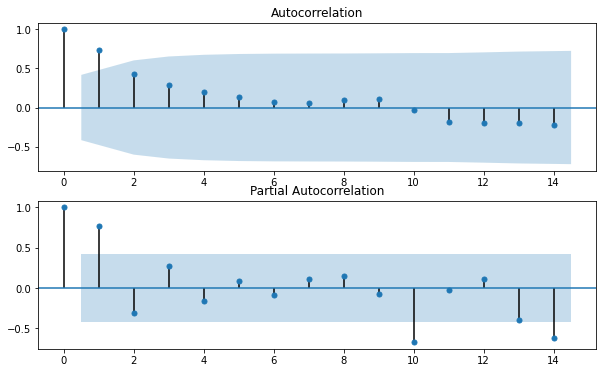

In [15]:
# ELSI
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0] = plot_acf(ClustData.ELSI, ax=ax[0])
ax[1] = plot_pacf(ClustData.ELSI, ax=ax[1])

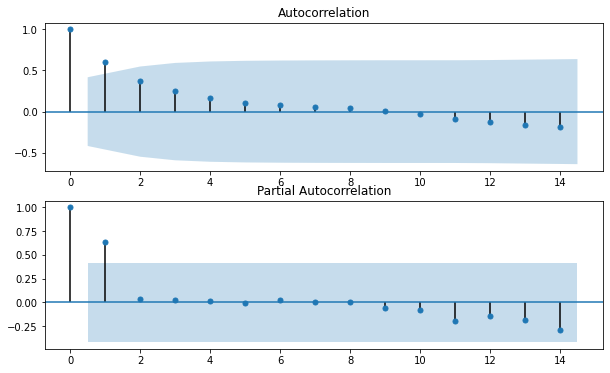

In [16]:
# SL
fig, ax = plt.subplots(2, figsize=(10,6))
ax[0] = plot_acf(ClustData.SL, ax=ax[0])
ax[1] = plot_pacf(ClustData.SL, ax=ax[1])

### Variational Autoregression Model

#### Johanson's cointegration test (if there exists a linear combination of the time-series with a difference order less that that of every individual one then the test says asserts that the time-series are cointegrated) for the clustered data

In [17]:
# We only have 22 data points. Therefore we choose to keep 17 as the training set 
# and the remainder as the validation
nobs = 4
X_train, X_test = ClustData[0:-nobs], ClustData[-nobs:]

print(X_train.shape, X_test.shape)

(18, 7) (4, 7)


In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(ClustData)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
SL     ::  168.93    > 111.7797  =>   True
UL     ::  96.27     > 83.9383   =>   True
RL     ::  52.38     > 60.0627   =>   False
ELSI   ::  26.91     > 40.1749   =>   False
FE     ::  9.92      > 24.2761   =>   False
RG     ::  1.71      > 12.3212   =>   False
RD     ::  0.12      > 4.1296    =>   False


This is an iterative step. For an autoregressional model to have predictive value, one needs to satisfy stationarity. The latter can be achieved by treating the series so as to represent a non-changing behaviour on average. Possible ways of doing this is by iteratively taking the consecutive differences (differencing) of the series until stationarity (see the upcoming test) is reached, taking iteratively the logarithm of the series (if applicable) or, accordingly, some root of the data.

In [19]:
ClustNames = ['SL', 'UL', 'RL', 'ELSI', 'FE', 'RG', 'RD']
# transform_data = pd.DataFrame(np.log(X_train.values), 
#                               index=list(range(1997,2015)), columns=ClustNames)
# TODO Bound to the augmented Dickson-Fuller test
transform_data = X_train.diff().dropna()
transform_data = transform_data.diff().dropna()
transform_data = transform_data.diff().dropna()
transform_data = transform_data.diff().dropna()
transform_data = transform_data.diff().dropna()
transform_data = transform_data.diff().dropna()
transform_data = transform_data.diff().dropna()
transform_data.head()

,SL,UL,RL,ELSI,FE,RG,RD
2004,9348.0,11987.0,-1105.0,2237.0,-42.0,-63.0,3.0
2005,-18655.0,-18257.0,1051.0,-2337.0,1514.0,72.0,-129.0
2006,27578.0,21584.0,1950.0,4297.0,-2551.0,38.0,536.0
2007,-29167.0,-17733.0,-5645.0,-6908.0,1939.0,-203.0,-1173.0
2008,16174.0,10190.0,6295.0,7878.0,-205.0,328.0,1680.0


In [20]:
transform_data.describe()

,SL,UL,RL,ELSI,FE,RG,RD
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,1451.636364,669.727273,-142.727273,-622.454545,19.272727,-31.090909,-87.363636
std,33889.985274,33391.942462,13659.772766,13340.631637,6477.577496,477.852164,2342.834662
min,-48488.000000,-55410.000000,-27221.000000,-21003.000000,-11280.000000,-865.000000,-4249.000000
25%,-23911.000000,-17995.000000,-6623.500000,-8872.000000,-2255.000000,-322.500000,-1385.000000
50%,9348.000000,10190.000000,324.000000,127.000000,-42.000000,38.000000,-129.000000
75%,23015.000000,18884.500000,4122.500000,6087.500000,2106.500000,240.500000,1108.000000
max,56982.000000,60572.000000,24296.000000,19695.000000,12890.000000,674.000000,3749.000000


### Stationarity check through the augmented Dickey-Fuller test

In [21]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):
        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]

        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False

        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [22]:
# Check the stationarity for all the clusters with a 5% significance level
for i in ClustNames:
    sTest = StationarityTests()
    sTest.ADF_Stationarity_Test(transform_data[i])
    print("Is the time series", i, "stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -9.774850e+00
P-Value                 6.978921e-17
# Lags Used             2.000000e+00
# Observations Used     8.000000e+00
Critical Value (1%)    -4.665186e+00
Critical Value (5%)    -3.367187e+00
Critical Value (10%)   -2.802961e+00
dtype: float64
Is the time series SL stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -20.472999
P-Value                  0.000000
# Lags Used              2.000000
# Observations Used      8.000000
Critical Value (1%)     -4.665186
Critical Value (5%)     -3.367187
Critical Value (10%)    -2.802961
dtype: float64
Is the time series UL stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.533276e+01
P-Value                 3.925461e-28
# Lags Used             3.000000e+00
# Observations Used     7.000000e+00
Critical Value (1%)    -4.938690e+00
Critical Value (5%)    -3.477583e+00
Critical Value (10%)   -2.843868e+00
dtype: float64
Is the 

### Plots of the clusters' time-series after their transformation. The data is sparse, making the analysis somewhat speculative. One can realize though through inspection that the SL and UL clusters fluctuate beyond a mean value, making them non-stationary.

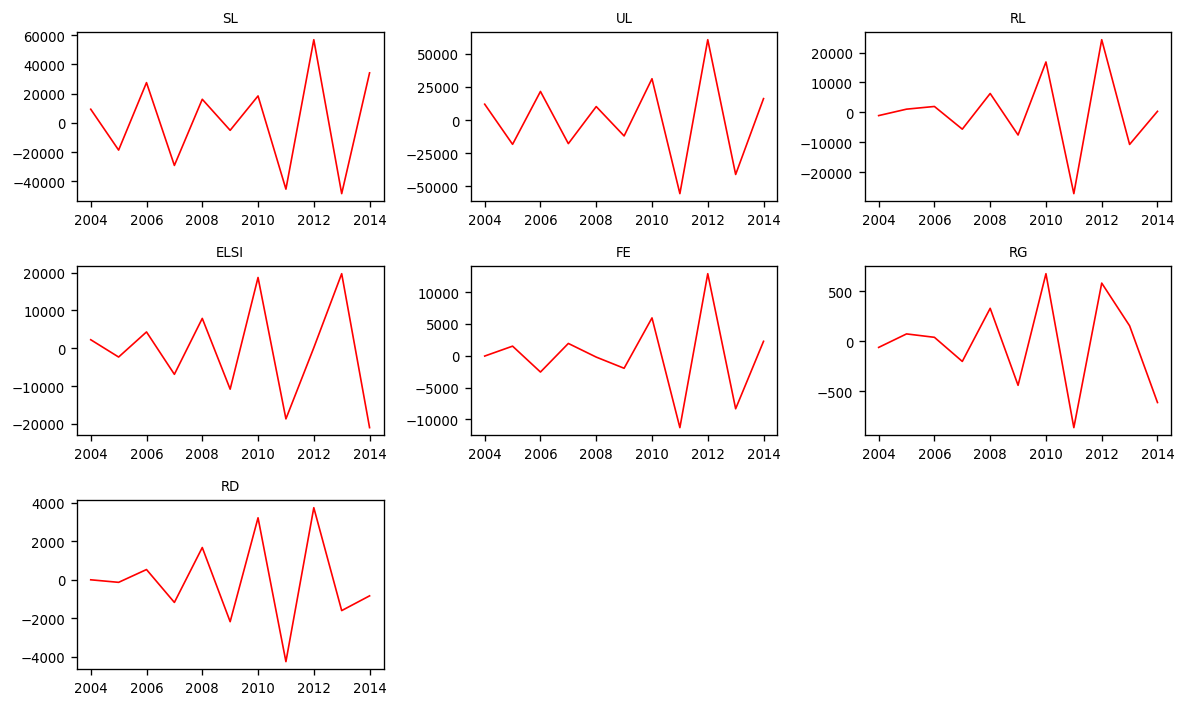

In [23]:
fig, axes = plt.subplots(3, 3, dpi=120, figsize=(10,6))
axes[-1,-2].axis('off')
axes[-1,-1].axis('off')

for i, ax in enumerate(axes.flatten()):
    if i <=6:
        data = transform_data[transform_data.columns[i]]
        ax.plot(data, color='red', linewidth=1)
        ax.set_title(transform_data.columns[i], fontsize=8)
        ax.tick_params(labelsize=8)
plt.tight_layout()

### Granger's causality test for a 5% statistical significance for the stationary clusters' time-series. The resulting matrix's elements gives the p-values of the test. Anything below 5% is considered to be Granger causal.

In [24]:
# with the available data we can only look at local causal relationships, 
# not spanning more than 2 lags-years
maxlag=2
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), imply validity of 
    the Null Hypothesis, i.e. that the coefficients of the corresponding past values are
    zero, that is, that X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

### The Granger causation matrix with a 5% stat. significance (anything below 5% is supposed to be Granger causal)

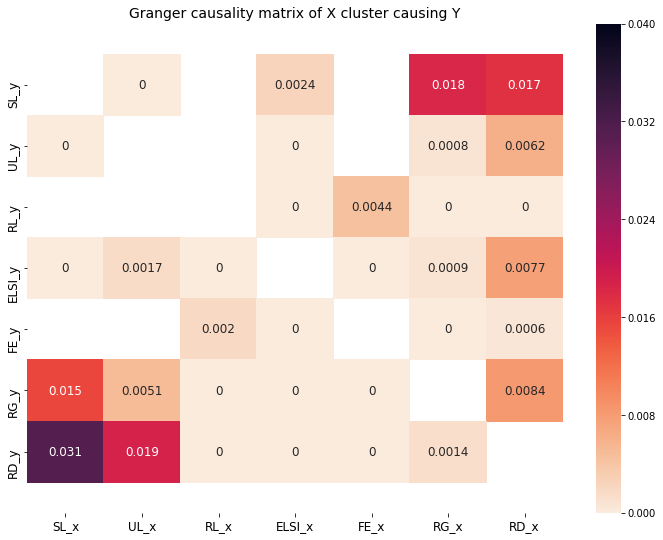

In [61]:
# StatTSeries = X_train.drop(['SL','UL'], axis=1)
mask = GClusters.values >= 0.05  # keep only values smaller than 5%
GClusters = grangers_causation_matrix(transform_data, variables=transform_data.columns)
plt.figure(figsize=(12,9))
cmap = sns.cm.rocket_r
ax = sns.heatmap(GClusters, mask = mask, xticklabels=GClusters.columns.values, cmap=cmap,
            yticklabels=GClusters.index, annot = True, annot_kws={'size' : 12}, vmin=0, vmax=0.04 )
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.tick_params(labelsize=12)
plt.title('Granger causality matrix of X cluster causing Y', fontsize=14)
# plt.savefig('./../Manuscripts/Images/Granger_Causation_Clusters', dpi=150)

In [26]:
grangercausalitytests(transform_data[['ELSI','ELSI']], 1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=8, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=9.8684  , p=0.0138  , df_denom=8, df_num=1


{1: ({'ssr_ftest': (1.2029415702132694e-15, 0.9999999674037099, 8.0, 1),
   'ssr_chi2test': (1.5036769627665868e-15, 0.9999999690602119, 1),
   'lrtest': (-0.0, 1.0, 1),
   'params_ftest': (9.86844977832528, 0.013775903552863806, 8.0, 1.0)},
   array([[0., 1., 0.]])])}

In [27]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

In [28]:
transform_data.shape

(11, 7)

In [45]:
model = VAR(transform_data)
for i in [1,2,3]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1


/home/stavrogin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


LinAlgError: 4-th leading minor of the array is not positive definite

### Discrete Fourier Transform (determining the dominant frequencies)

In [21]:
y = {}
x = {}
for i in ClustNames:
    y[i] = np.fft.rfft(ClustData[i])
    x[i] = ClustData[i].index.shape[0]/np.arange(1,y[i].shape[0])
    y[i] = np.abs(y[i])[1:] ** 2.

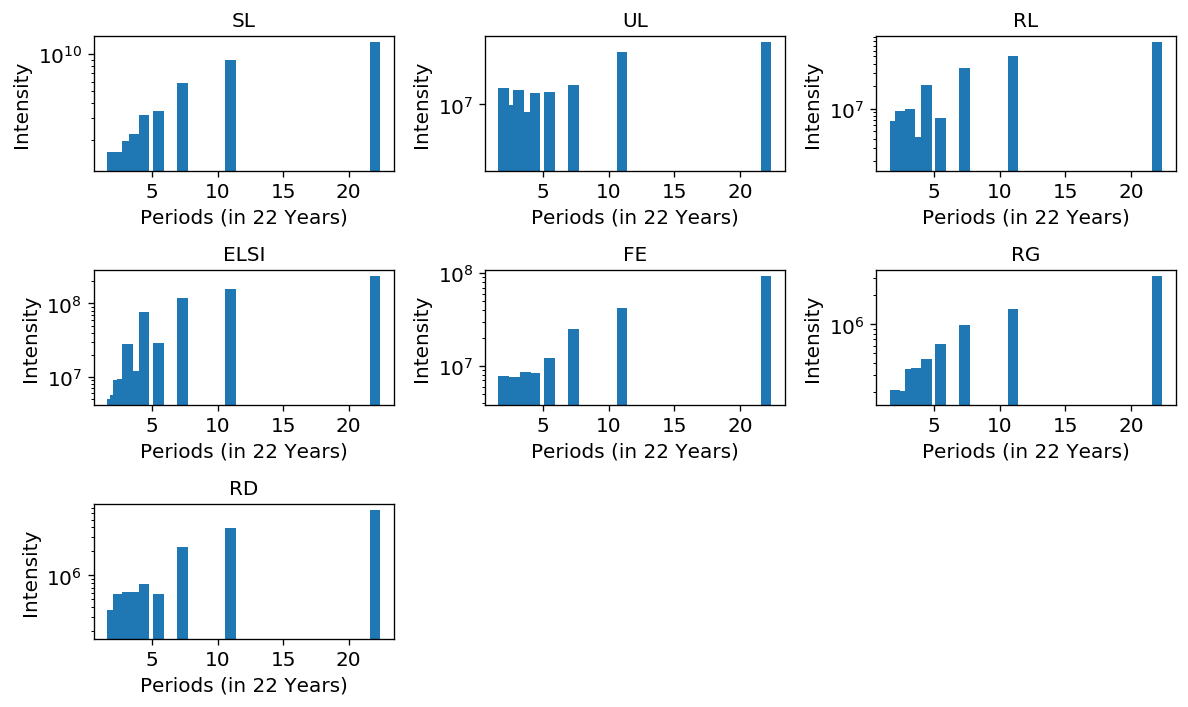

In [37]:
fig, axes = plt.subplots(3, 3, dpi=120, figsize=(10,6))
axes[-1,-2].axis('off')
axes[-1,-1].axis('off')

for i, ax in zip(ClustNames, axes.flatten()):
    ax.bar(x[i],y[i])
    # plt.xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Intensity', fontsize=12)
    ax.set_xlabel('Periods (in 22 Years)', fontsize=12)
    ax.tick_params(labelsize=12)
    ax.set_title(i)

plt.tight_layout()
# plt.savefig('./../Manuscripts/Images/Cluster_DFT', dpi=150)

### Wavelet analysis (tentative)

**WARNING**: This part of the analysis uses an [external package](https://github.com/aaren/wavelets) for wavelet analysis. This package is copyrighted by Aaron O'Leary under the MIT License, granting free use of the code.

We use [Morlet](https://en.wikipedia.org/wiki/Morlet_wavelet) basis function.

In [28]:
from wavelets import WaveletAnalysis

In [29]:
dt = 0.1  # sample spacing

wa = WaveletAnalysis(transform_data['ELSI'].values, dt=dt)
# wa = WaveletAnalysis(ClustData['ELSI'].values, dt=dt)

# wavelet power spectrum
power = wa.wavelet_power

# scales 
scales = wa.scales

# associated time vector
t = wa.time

# reconstruction of the original data
rx = wa.reconstruction()

/home/stavrogin/anaconda3/lib/python3.7/site-packages/wavelets/transform.py:104: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  wavelet_data[slices],


According to wavelet theory and the documentation of the algorithm, the time-series  must be localized in the time-frequency domain and have a zero mean. So our  transformed (static) ones best serve this property. The results are obviously radically different if we use the original time-series

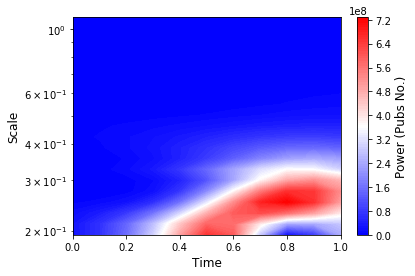

In [30]:
fig, ax = plt.subplots()
T, S = np.meshgrid(t, scales)
cax = ax.contourf(T, S, power, 100, cmap='bwr')
ax.set_yscale('log')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Scale', fontsize=12)
cbar = fig.colorbar(cax)
cbar.set_label('Power (Pubs No.)', fontsize=12)